In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('quora-question-pairs/train.csv')
#test = pd.read_csv('quora-question-pairs/test.csv')

In [4]:
train['question1'] = train['question1'].astype(str)
train1 = [i.split(' ') for i in train['question1'].values.tolist()]

train['question2'] = train['question2'].astype(str)
train2 = [i.split(' ') for i in train['question2'].values.tolist()]

labels = train['is_duplicate'].values.tolist()

In [5]:
#test['question1'] = test['question1'].astype(str)
#test1 = [i.split(' ') for i in test['question1'].values.tolist()]

#test['question2'] = test['question2'].astype(str)
#test2 = [i.split(' ') for i in test['question2'].values.tolist()]

In [6]:
import fasttext

ft_en = fasttext.load_model('cc.en.300.bin')

def get_ft(word):
    return ft_en.get_word_vector(word)

In [7]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 15
LEARNING_RATE = 0.05
LSTM_LAYERS = 2
DROPOUT = 0.1
EPOCHS = 1
KEY_DIM = 2*LSTM_LAYERS*HIDDEN_DIM
OUT_DIM = 2*HIDDEN_DIM

In [8]:
class AttentionLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(AttentionLSTM, self).__init__()
        
        self.w1 = 0
        self.w2 = 0
        self.w_matrix1 = 0
        self.w_matrix2 = 0
        self.al1 = 0
        self.al2 = 0
        self.similarity = 0
        self.predict = 0
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = LSTM_LAYERS, dropout = DROPOUT, bidirectional = True)
        self.Bilinear = nn.Bilinear(EMBEDDING_DIM+OUT_DIM, EMBEDDING_DIM+OUT_DIM, 1)
        
        #self.inp = nn.Linear(6, 12)
        #self.hidden1 = nn.Linear(12, 12)
        #self.hidden2 = nn.Linear(8, 8)
        #self.hidden3 = nn.Linear(8, 8)
        #self.out = nn.Linear(12, 1)
        
        self.linear = nn.Linear(4, 1)
        
        self.norm1 = nn.LayerNorm(2*OUT_DIM)
        self.norm2 = nn.LayerNorm(EMBEDDING_DIM+OUT_DIM)
        
        self.Key = nn.Linear(EMBEDDING_DIM+OUT_DIM, KEY_DIM)

    def forward(self, sentence1, sentence2):
        
        out1, (hidden_state1, _) = self.lstm(sentence1.view(len(sentence1), 1, -1))
        out2, (hidden_state2, _) = self.lstm(sentence2.view(len(sentence2), 1, -1))
        
        out1 = torch.cat((out1.view(len(sentence1), -1), sentence1), dim=1) 
        out2 = torch.cat((out2.view(len(sentence2), -1), sentence2), dim=1) 
        
        query1 = hidden_state1.view(-1)
        query2 = hidden_state2.view(-1)
        
        keys1 = self.norm1(self.Key(out1))
        keys2 = self.norm1(self.Key(out2))
        
        keys1 = keys1.view(-1,KEY_DIM)
        keys2 = keys2.view(-1,KEY_DIM)
        
        cos = nn.CosineSimilarity(dim = -1)
        
        weights1 = cos(keys1, query1)
        weights2 = cos(keys2, query2)
        
        threshold1 = 1/(4+len(sentence1))
        threshold2 = 1/(4+len(sentence2))

        t1 = nn.Threshold(threshold1, 0)
        t2 = nn.Threshold(threshold2, 0)
        
        weights1 = t1(F.softmax(weights1, dim = 0))
        weights2 = t2(F.softmax(weights2, dim = 0))
        
        weights1 = weights1/weights1.sum()
        weights2 = weights2/weights2.sum()
        
        self.w1 = weights1
        self.w2 = weights2
        
        #print ("Weights 1 ", weights1.view(1,-1).unsqueeze(0).shape)
        #print ("Weights 1 ", sentence1.unsqueeze(0).shape)
        
        h1 = torch.bmm(weights1.view(1,-1).unsqueeze(0),out1.unsqueeze(0))
        h2 = torch.bmm(weights2.view(1,-1).unsqueeze(0),out2.unsqueeze(0))
        
        similarity = cos(h1,h2)
        
        self.similarity = similarity.view(-1).item()
        
        n1 = self.norm2(h1)
        n2 = self.norm2(h2)
        
        #Weight Matrix
        w_mat = torch.matmul(keys1,torch.transpose(keys2,1,0))
        w_mat1 = F.softmax(w_mat, dim = 1)
        w_mat2 = F.softmax(w_mat, dim = 0)
        
        self.w_matrix1 = w_mat1
        self.w_matrix2 = w_mat2
        
        alignment1 = torch.matmul(weights1.view(1,-1),w_mat1)
        alignment1 = torch.matmul(alignment1,weights2.view(-1,1))
        
        alignment2 = torch.matmul(weights1.view(1,-1),w_mat2)
        alignment2 = torch.matmul(alignment2,weights2.view(-1,1))
                
        self.al1 = alignment1.view(-1).item()
        self.al2 = alignment2.view(-1).item()
        #y_predict = torch.sigmoid(self.linear(alignment))
        #y_predict = torch.sigmoid(self.linear(cos(h1,h2)))
        
        predict1 = torch.sigmoid(self.Bilinear(h1,h2))
        
        self.predict = predict1.view(-1).item()
                
        #f1 = -torch.abs(alignment1.view(-1) - alignment2.view(-1))/(self.al1 + self.al2)
        #f2 = torch.tensor([(self.al1 + self.al2)*(len(sentence1) + len(sentence2))]).to(device)
        
        final = torch.stack((similarity.view(-1), predict1.view(-1), alignment1.view(-1), alignment2.view(-1)),0).view(-1)
        
        
        #y_predict = torch.sigmoid(self.out(outv))
        
        #outv = torch.tanh(self.inp(final))
        #hid2 = F.relu(self.hidden1(hid1))
        #hid3 = F.relu(self.hidden2(hid2))
        #outv = F.relu(self.hidden1(hid1))
        
        y_predict = torch.sigmoid(self.linear(final))

        return y_predict
    

In [10]:
#test cell
model = AttentionLSTM(EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)

for i in range(len(train1[0:1])):
    sentence1 = train1[i+1]
    sentence2 = train2[i+1]
    
    inputs1 = torch.tensor([get_ft(word) for word in sentence1])
    inputs2 = torch.tensor([get_ft(word) for word in sentence2])
    y_predict = model(inputs1.to(device), inputs2.to(device))
    
    print (sentence1)
    #print (model.w1)
    print (sentence2)
    #print (model.w2)
    #print (model.w_matrix)
    #print ("Similarity ",model.similarity)
    #print ("Predict ",model.predict)
    #print ("Al1 ",model.al1)
    #print ("Al2 ",model.al2)
    print (y_predict)


['What', 'is', 'the', 'story', 'of', 'Kohinoor', '(Koh-i-Noor)', 'Diamond?']
['What', 'would', 'happen', 'if', 'the', 'Indian', 'government', 'stole', 'the', 'Kohinoor', '(Koh-i-Noor)', 'diamond', 'back?']
tensor([0.5692], device='cuda:0', grad_fn=<SigmoidBackward>)


In [ ]:
def train(epoch, model, loss_function, optimizer):
    train_loss = 0
    correct = 0
    num = 0
    labels1 = np.array(labels)
    label2 = torch.from_numpy(labels1)
    label2 = label2.type(torch.float)
    start_time = time.time()
    
    for i in range(len(train1)):
        num = num + 1
        
        if i%10000 == 0:
            print("No. ",i ," Epoch: ", epoch, " Loss: ", train_loss/(2*num), "Accuracy: ",correct/(2*num), "Time taken: ", time.time()-start_time)
            start_time = time.time()
        model.zero_grad()
        
        sentence1 = train1[i]
        sentence2 = train2[i]
        inputs1 = torch.tensor([get_ft(word) for word in sentence1])
        inputs2 = torch.tensor([get_ft(word) for word in sentence2])
    

        y_predict1 = model(inputs1.to(device), inputs2.to(device))
        y_predict2 = model(inputs2.to(device), inputs1.to(device))
        
        labela = torch.tensor([label2[i]])
        
        y_predict = torch.stack((y_predict1,y_predict2),0).view(-1)
        label = torch.stack((labela,labela),0).view(-1)
        
        #y_predict = y_predict1.view(-1)
        #label = labela.view(-1)
        
        #print (y_predict, label)
        
        loss = loss_function(y_predict.to(device), label.to(device))

        loss.backward()
        optimizer.step()

        train_loss += loss.float().sum().item()

        preds = torch.round(y_predict.to(device))

        matches = (preds == label.to(device)).float().sum() 
        correct += matches.item()
        
        #print (preds, label, correct)
        
        
    print("Epoch: ", epoch, " Loss: ", train_loss/(2*num), "Accuracy: ",correct/(num))


In [12]:
model = AttentionLSTM(EMBEDDING_DIM, HIDDEN_DIM)
model.load_state_dict(torch.load('Attention_new_4.pth'))
#copied_params = load_my_state_dict(model,torch.load('Attention_new_3.pth'))
model = model.to(device)
loss_function = nn.BCELoss()

In [141]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for epoch in range(1, EPOCHS + 1): 
    train(epoch, model, loss_function, optimizer)

No.  0  Epoch:  1  Loss:  0.0 Accuracy:  0.0 Time taken:  0.0
No.  10000  Epoch:  1  Loss:  0.20059565869341542 Accuracy:  0.8107189281071893 Time taken:  422.2083921432495
No.  20000  Epoch:  1  Loss:  0.19979385865980573 Accuracy:  0.8131843407829609 Time taken:  418.9606068134308
No.  30000  Epoch:  1  Loss:  0.19936978792382476 Accuracy:  0.8137728742375254 Time taken:  439.226313829422


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
print (model.state_dict()['linear.weight'], model.state_dict()['linear.bias'])

In [ ]:
torch.save(model.state_dict(), 'Attention_new_5.pth')

In [40]:
new_model = AttentionLSTM(EMBEDDING_DIM, HIDDEN_DIM)
new_model.load_state_dict(torch.load('Attention_new_5.pth'))

<All keys matched successfully>

In [41]:
model = new_model
model.to(device)

AttentionLSTM(
  (lstm): LSTM(300, 15, num_layers=2, dropout=0.1, bidirectional=True)
  (Bilinear): Bilinear(in1_features=330, in2_features=330, out_features=1, bias=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((330,), eps=1e-05, elementwise_affine=True)
  (Key): Linear(in_features=330, out_features=60, bias=True)
)

In [13]:
import random

In [159]:
q1 = "Why is Israel fighting ISIS?"
q2 = "How is Israel fighting ISIS?" 

In [ ]:
q1 = "What are the best ways to learn French?"
q2 = "How do I learn french genders?" 

In [37]:
q1 = "What is the most foolish thing you did as a kid?"
q2 = "What is the most intelligent thing a kid has ever said to you?" 

In [48]:
q1 = "What will be the effect of banning 500 and 1000 Rs notes on real estate sector in India?"
q2 = "Can we expect sharp fall in prices in short/long term? What will the real estate look like now after the 500 and 1000 scraping?"

In [160]:
t1 = q1.split(' ')
t2 = q2.split(' ')

In [184]:
i = random.randint(1,400000)
t1 = train1[i]
t2 = train2[i]

In [185]:
i1 = torch.tensor([get_ft(word) for word in t1])
i2 = torch.tensor([get_ft(word) for word in t2])

y1 = model(i1.to(device),i2.to(device))
#y2 = model(i2.to(device),i1.to(device))

In [186]:
print (y1)
print (labels[i])

tensor([0.7288], device='cuda:0', grad_fn=<SigmoidBackward>)
1


In [187]:
print (t1)
print (model.w1.tolist())

['Where', 'can', 'I', 'find', 'an', 'online', 'course', 'for', 'digital', 'marketing?']
[0.11732912808656693, 0.0, 0.0, 0.0, 0.0, 0.12121795862913132, 0.11910372972488403, 0.0, 0.23030225932598114, 0.41204696893692017]


In [188]:
print (t2)
print (model.w2.tolist())

['What', 'is', 'the', 'best', 'digital', 'marketing', 'course', 'online', 'for', 'a', 'beginner?']
[0.0, 0.0, 0.0, 0.0, 0.18022485077381134, 0.21090812981128693, 0.11719606071710587, 0.0, 0.0, 0.0, 0.4916709363460541]


In [189]:
print ("Similarity ",model.similarity)
print ("Predict ",model.predict)
print ("Al1 ",model.al1)
print ("Al2 ",model.al2)

Similarity  0.8480792045593262
Predict  0.3596404790878296
Al1  0.24409519135951996
Al2  0.20171818137168884


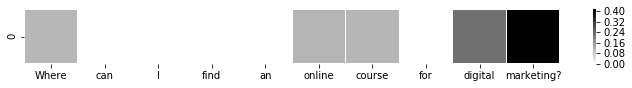

In [190]:
s1 = np.array([model.w1.tolist()])
plt.figure(figsize=(12, 1))
sns.heatmap(s1, cmap = "gray_r", xticklabels=t1, linewidths=.3)

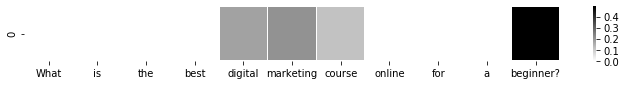

In [191]:
s2 = np.array([model.w2.tolist()])
plt.figure(figsize=(12, 1))
sns.heatmap(s2, cmap = "gray_r", xticklabels=t2, linewidths=.3)

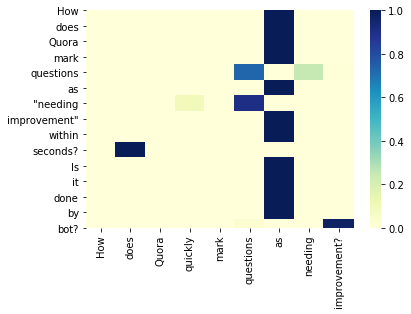

In [141]:
map1 = model.w_matrix1.cpu().detach().numpy()
sns.heatmap(map1, cmap="YlGnBu", yticklabels=t1, xticklabels=t2)

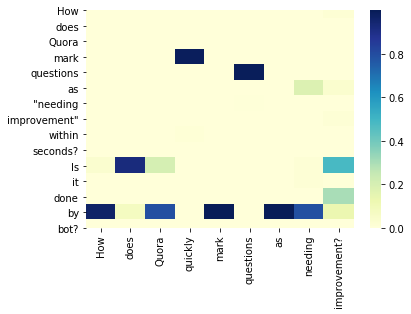

In [142]:
map2 = model.w_matrix2.cpu().detach().numpy()
sns.heatmap(map2, cmap="YlGnBu", yticklabels=t1, xticklabels=t2)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.SGD(new_model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1): 
    train(epoch, new_model, loss_function, optimizer)

In [294]:
#Epochs 2 and 3
for epoch in range(1, EPOCHS + 1): 
    train(epoch, model, loss_function, optimizer)

No.  0  Epoch:  1  Loss:  0.0 Accuracy:  0.0 Time taken:  0.0
No.  10000  Epoch:  1  Loss:  0.2410998192267152 Accuracy:  0.7528247175282472 Time taken:  413.37073612213135
No.  20000  Epoch:  1  Loss:  0.2420534116683586 Accuracy:  0.7519874006299685 Time taken:  412.23864674568176
No.  30000  Epoch:  1  Loss:  0.24138644035406795 Accuracy:  0.7536915436152128 Time taken:  413.02196192741394
No.  40000  Epoch:  1  Loss:  0.24009789331488918 Accuracy:  0.7555811104722382 Time taken:  409.6203303337097
No.  50000  Epoch:  1  Loss:  0.23863925018899865 Accuracy:  0.7572548549029019 Time taken:  407.06764554977417
No.  60000  Epoch:  1  Loss:  0.23889463828258586 Accuracy:  0.757529041182647 Time taken:  405.34272289276123
No.  70000  Epoch:  1  Loss:  0.23816679083820516 Accuracy:  0.7587034470936129 Time taken:  409.5759701728821
No.  80000  Epoch:  1  Loss:  0.23848777950793115 Accuracy:  0.7580467744153198 Time taken:  403.6522150039673
No.  90000  Epoch:  1  Loss:  0.2381640893086401

No.  330000  Epoch:  2  Loss:  0.22518902940347843 Accuracy:  0.7781249147729855 Time taken:  401.58642053604126
No.  340000  Epoch:  2  Loss:  0.22506143510749946 Accuracy:  0.7783035932247259 Time taken:  402.2280354499817
No.  350000  Epoch:  2  Loss:  0.2249427030186464 Accuracy:  0.7784549187002323 Time taken:  401.15871953964233
No.  360000  Epoch:  2  Loss:  0.22495517784111077 Accuracy:  0.7783603378879503 Time taken:  402.88924407958984
No.  370000  Epoch:  2  Loss:  0.22480135878892987 Accuracy:  0.7785695173796827 Time taken:  404.45217204093933
No.  380000  Epoch:  2  Loss:  0.22460825280714128 Accuracy:  0.7788032136757534 Time taken:  401.8768222332001
No.  390000  Epoch:  2  Loss:  0.22436539991591958 Accuracy:  0.7789595411293817 Time taken:  405.1810441017151
No.  400000  Epoch:  2  Loss:  0.22409477569683248 Accuracy:  0.7791230521923695 Time taken:  415.47996401786804
Epoch:  2  Loss:  0.22398333652237246 Accuracy:  0.7792500432857602
